# Домашнее задание 2. Преобразование данных

Цель этого задания -- преобразовать имеющиеся атрибуты пользователей в признаки так, чтобы полученная матрица признаков была пригодна для подачи в алгоритм кластеризации. Этап конструирования признаков -- самый важный и обычно самый долгий. К нему возвращаются много раз на протяжении решения задачи анализа данных.

Кроме библиотек, использованных в первом задании, нам понадобятся следующие библиотеки:
1. [scikit-learn](http://scikit-learn.org/stable/) -- библиотека, реализующая множество алгоритмов машинного обучения и сопутствующих алгоритмов

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.preprocessing as sp
import csv
import re
import dateutil
from itertools import combinations, ifilter
from itertools import product as iproduct
from collections import defaultdict
np.set_printoptions(linewidth=150, precision=3, suppress=True)
from matplotlib.colors import ListedColormap

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
ts_parser = lambda date_str: datetime.datetime.strptime(date_str, "%Y-%m") if pd.notnull(date_str) and date_str else None
df_users = pd.read_csv("hw1_out.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC, converters={"created_at": ts_parser})
# Remove rows with users not found
df_users = df_users[pd.notnull(df_users['name'])]
df_users["lat"].fillna(value=0, inplace=True)
df_users["lon"].fillna(value=0, inplace=True)

Далее необходимо ввести новые признаки. Для каждого пользователя предлагается ввести следующие признаки:
- name_words - количество слов в имени
- screen_name_length - количество символов в псевдониме
- description_length - длина описания
- created_year - год создания аккаунта
- country_code - код страны
- verified - предлагается перевести в тип int

(2 балла)

In [3]:
dt = defaultdict(int)
dt[np.nan] = 0
def getFromCountryMapper(x):
    if not x in dt:
        dt[x] = len(dt)
    return dt[x]

In [4]:
countryMapper = defaultdict(int)
def create_new_features(df_users, features):
    # Introduce new features
    new_features = ["name_words", "screen_name_length", "description_length", "created_year", "country_code", "verified"]
    features.extend(new_features)
    
    df_users['name_words'] = df_users.name.apply(lambda x : len(x.split()) if pd.notnull(x) else 0) 
    df_users['screen_name_length'] = df_users.screen_name.apply(lambda x : len(x) if pd.notnull(x) else 0)
    df_users['description_length'] = df_users.description.apply(lambda x : len(x) if pd.notnull(x) else 0)
    df_users['created_year'] = df_users.created_at.apply(lambda x : x.year if pd.notnull(x) else np.nan)
    df_users['country_code'] = df_users.country.apply(lambda x : getFromCountryMapper(x))
    df_users['verified'] = df_users.verified.apply(lambda x : 1 if (pd.notnull(x) and x) else 0 if pd.notnull(x) else np.nan)
    return df_users, features

In [5]:
features = ["lat", "lon", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
df_users, features = create_new_features(df_users, features)
x = df_users[pd.notnull(df_users.cls)][features].values
y = df_users[pd.notnull(df_users.cls)]["cls"].values

Посмотрим, являются ли какие-либо из выбранных признаков сильно скоррелированными. Для этого посчитаем матрицу корреляций и выберем те пары признаков, абсолютное значения коэффициента корреляции между которыми больше 0.2. Необходимо реализовать функцию find_correlated_features, в которой нужно рассчитать коэффициенты корелляции и вывести те, которые больше 0.2. Подсказка: предлагается найти необходимую функцию в библиотеке np и реализовать find_correlated_features с использованием не более 5 строк кода (включая заголовок функции). (2 балла)

In [6]:
def find_correlated_features(x, features):
    correlation = numpy.corrcoef(x, rowvar=0)
    for i, j in combinations(range(0,len(features)), 2):
            if i < j and abs(correlation[i][j]) > 0.2:
                print "Correlated features: {0} + {1} -> {2:.2f}".format(features[i], features[j], correlation[i][j])
                

In [7]:
find_correlated_features(x, features)

Correlated features: lat + lon -> -0.63
Correlated features: lon + country_code -> 0.27
Correlated features: followers_count + friends_count -> 0.39
Correlated features: followers_count + listed_count -> 0.69
Correlated features: followers_count + verified -> 0.36
Correlated features: friends_count + listed_count -> 0.38
Correlated features: statuses_count + favourites_count -> 0.27
Correlated features: statuses_count + listed_count -> 0.20
Correlated features: statuses_count + created_year -> -0.21
Correlated features: listed_count + verified -> 0.35


Выделилось 3 группы признаков:
1. Основанные на географии:  "lat", "lon", "country_code"
2. Основанные на социальной активности:  "verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"
3. Остальные:  "name_words", "screen_name_length", "description_length"

Построим взаимные распределения пар признаков в каждой из групп, а также гистограмму значений каждого из признаков с учетом целевой переменной.

In [8]:
def plot_two_features_scatter(x_i, x_j, y, size = 20):
    neg_pos_map = ListedColormap(['red', 'green'])
    pl.scatter(x = x_i, y = x_j, c = y, cmap = neg_pos_map, s = size, alpha = 0.75, facecolor='0.5', lw = 0)

    
def plot_feature_histogram(x_i, y):
    pl.hist([x_i[y == 0], x_i[y == 1]], label = ["negative", "positive"], color = ['red', 'green'])


def plot_dataset(x, y, features):
    pointSize = 20 * 9 / (len(features) ** 2)
    fig = pl.figure(figsize=(20, 20))
    gridSize = len(features)
    for i, j in iproduct(range(len(features)), repeat = 2):
        subpl = pl.subplot(gridSize, gridSize, j * gridSize + i + 1)
        subpl.set_xticklabels([])
        subpl.set_yticklabels([])
        
        if j == 0:
            pl.title(features[i])
        if i == 0:
            pl.ylabel(features[j])
            
        if i != j:
            plot_two_features_scatter(x[:, i], x[:, j], y, size = pointSize)
        else:
            plot_feature_histogram(x[:, i], y)

    pl.show()


Построим попарные распределения географических признаков ([подсказка](http://stroykova.github.io/sphera/l2_1.png)).

In [9]:
features_index_mapper = {f : i for i, f in enumerate(features)} # really better way for retriving positions


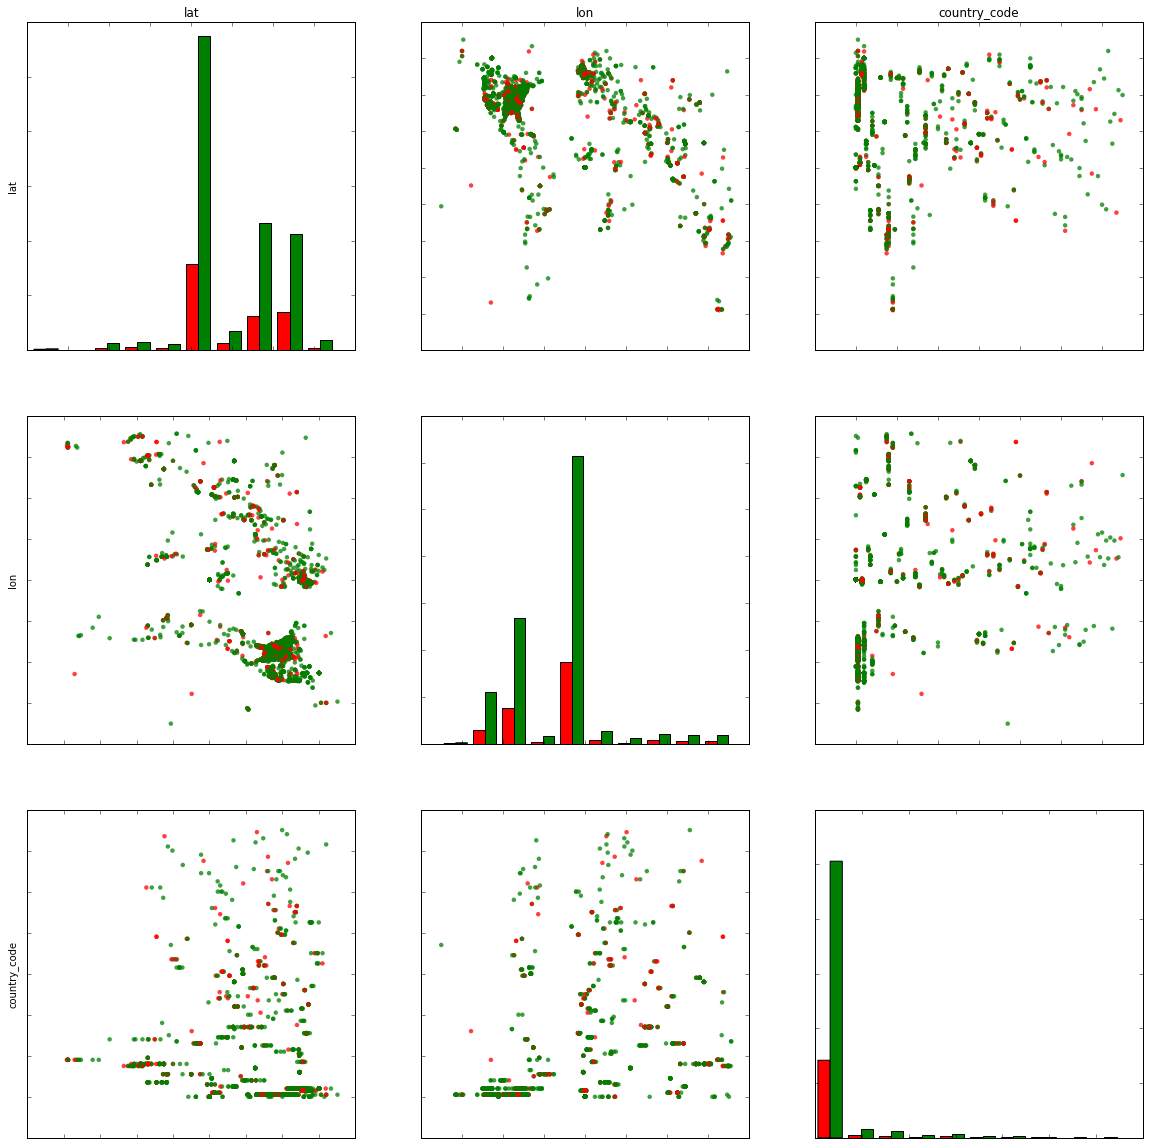

In [10]:
geo_features_new = ["lat", "lon", "country_code"]
geo_features = [f for f in geo_features_new if f in features]
geo_feature_ind = [features_index_mapper[f] for f in geo_features] 
plot_dataset(x[:, geo_feature_ind], y, geo_features)


Четко видны очертания карты и то, что большинство пользователей происходят из небольшого набора стран. Если принять во внимание конечную цель -- кластеризацию пользователей -- логично предположить, что использование географических признаков для описания пользователя может оказаться не очень полезным. Причина в том, что эти признаки четко пространственно разделены (как минимум, океанами и морями). Поэтому мы рискуем вместо "интересной" кластеризации получить просто кластеры, которые будут представлять разные страны. В дальнейшем мы исключим географические признаки из рассмотрения при кластеризации пользователей.

Далее построим попарные распределения социальных признаков ([подсказка](http://stroykova.github.io/sphera/l2_2.png)).

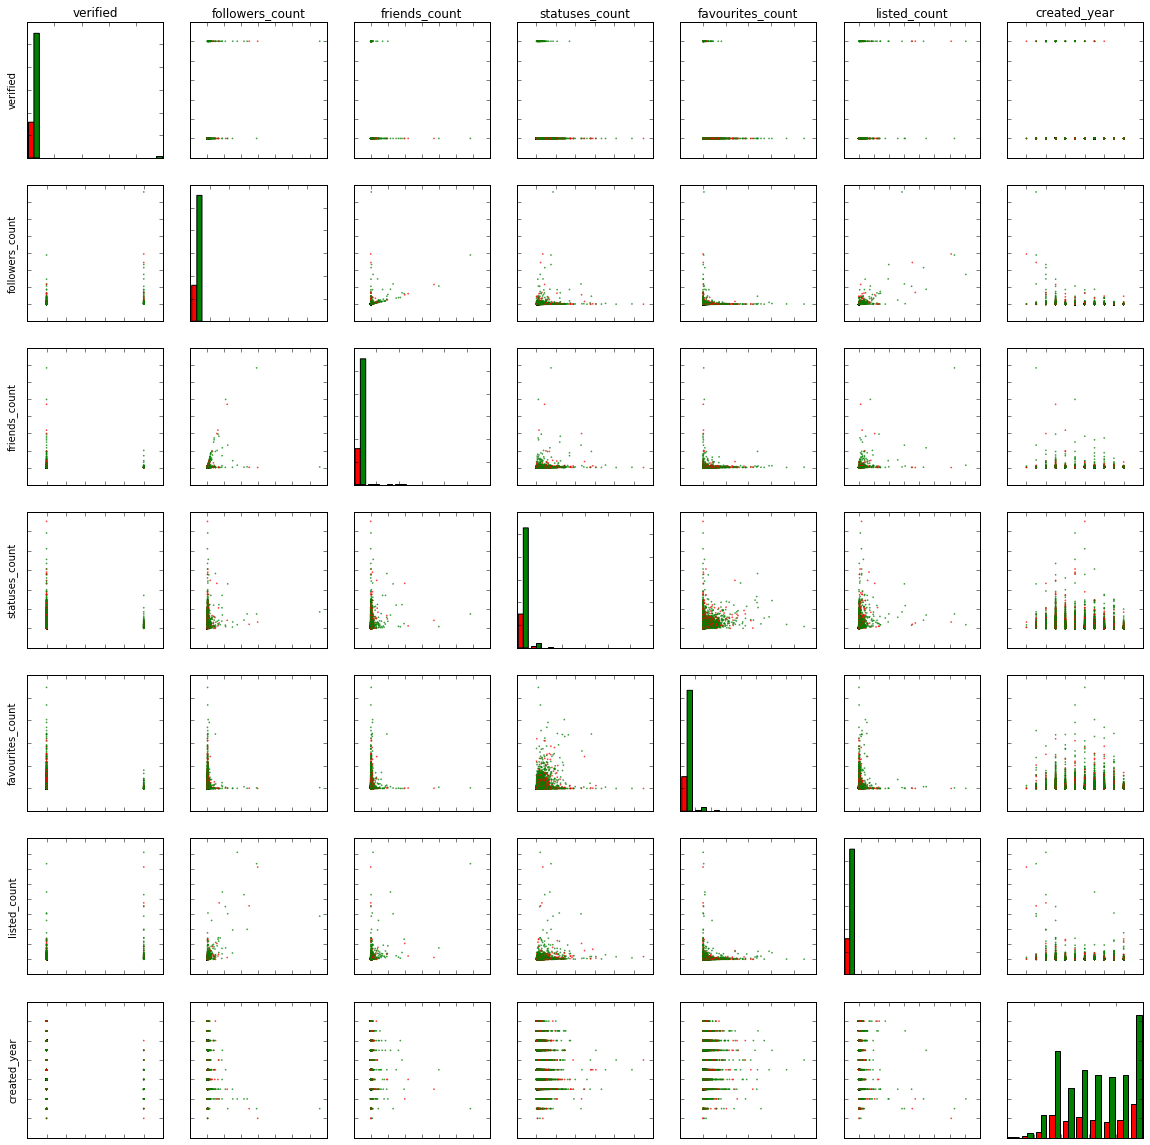

In [11]:
social_features_new = ["verified", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count", "created_year"]
social_features = [f for f in social_features_new if f in features]
social_feature_ind = [features_index_mapper[f] for f in social_features]
plot_dataset(x[:, social_feature_ind], y, social_features)

Из графиков видно, что признаки "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count" сильно смещены в сторону небольших значений. В таком случае удобно сделать логарифмическое преобразрвание этих признаков, то есть применить к их значениям $x_{ij}$ функцию $\log(1 + x_{ij})$. Сделаем это и построим новые распределения ([подсказка](http://stroykova.github.io/sphera/l2_3.png)). Необходимо реализовать функцию log_transform_features, которая выполняет указанное логарифмическое преобразование. (2 балла)

In [12]:
def log_transform_features(data, features, transformed_features):
    transorfmed_set = set(transformed_features) # we can dont care about order here
    transformed_features_ind= [ind for ind in xrange(len(features)) if features[ind] in transorfmed_set]
    # transform selected features with log function
    data[:, transformed_features_ind] = np.log(data[:, transformed_features_ind] + 1)
    return data

In [13]:
transformed_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"]
x = log_transform_features(x, features, transformed_features)

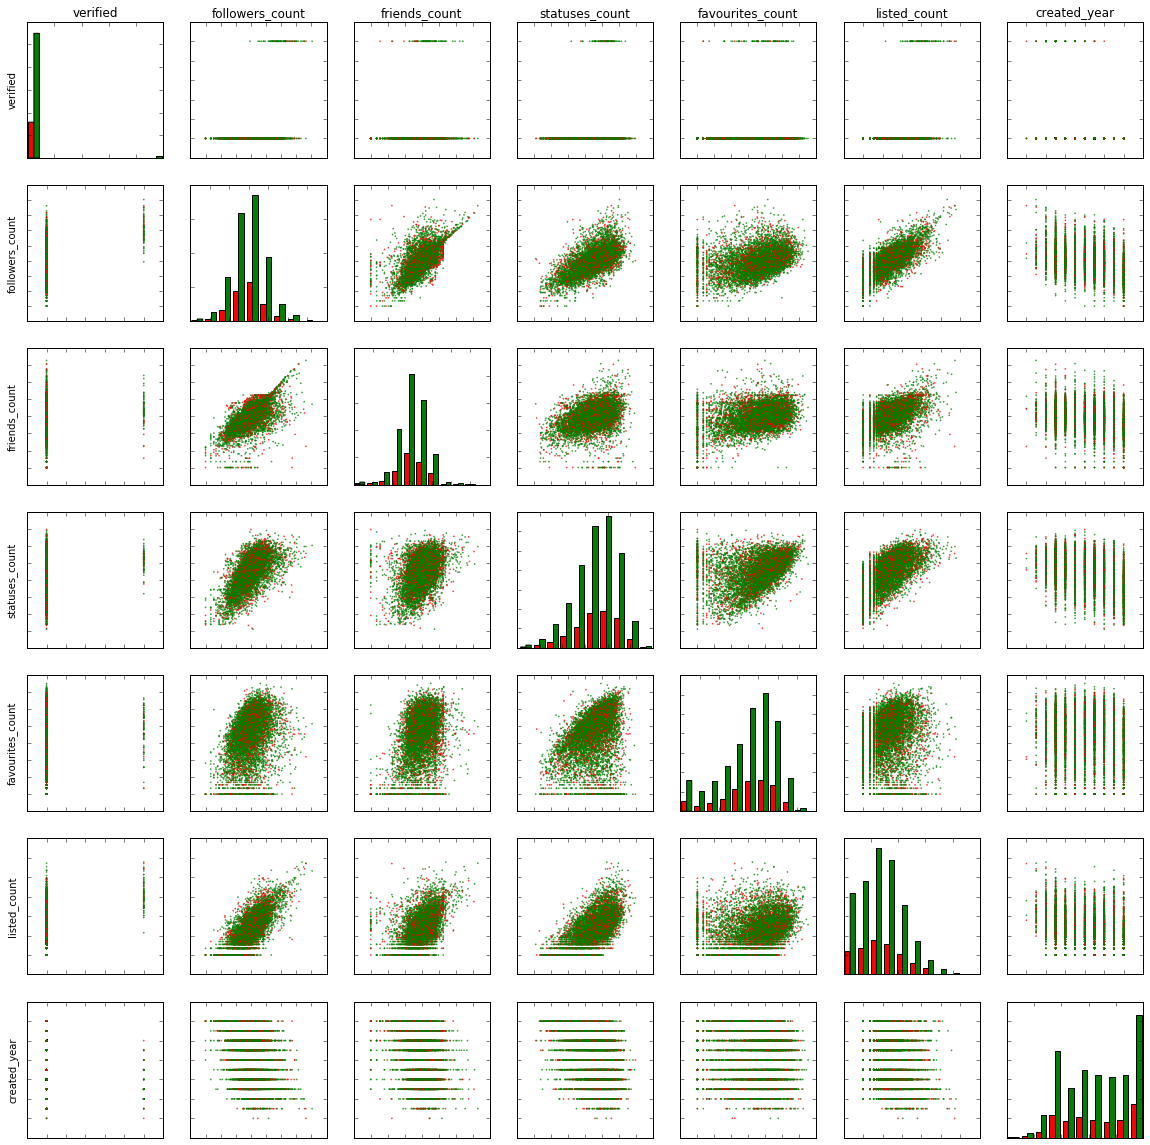

In [14]:
# Re-plot features

plot_dataset(x[:, social_feature_ind], y, social_features)

Сразу бросается в глаза, что признак "verified" сильно смещен -- верифицированных пользователей очень мало. Более того, все верифицированные пользователи имеют много фолловеров, поэтому часть информации о верификации дублируется в признаке "followers_count". По этой причине в дальнейшем не будем рассматривать признак "verified".

После того как мы с помощью логрифмического преобразования избавились от сильной скошенности признаков, можно наблюдать некоторые интересные зависимости. Например, пользователи, имеющие много фолловеров, обязательно имеют много статусов. Следовательно, чтобы стать популярным, обязательно нужно много писать. Анализ других зависимостей остается как упражнение.

Наконец построим попарные распределения остальных признаков ([подсказка](http://stroykova.github.io/sphera/l2_4.png)).

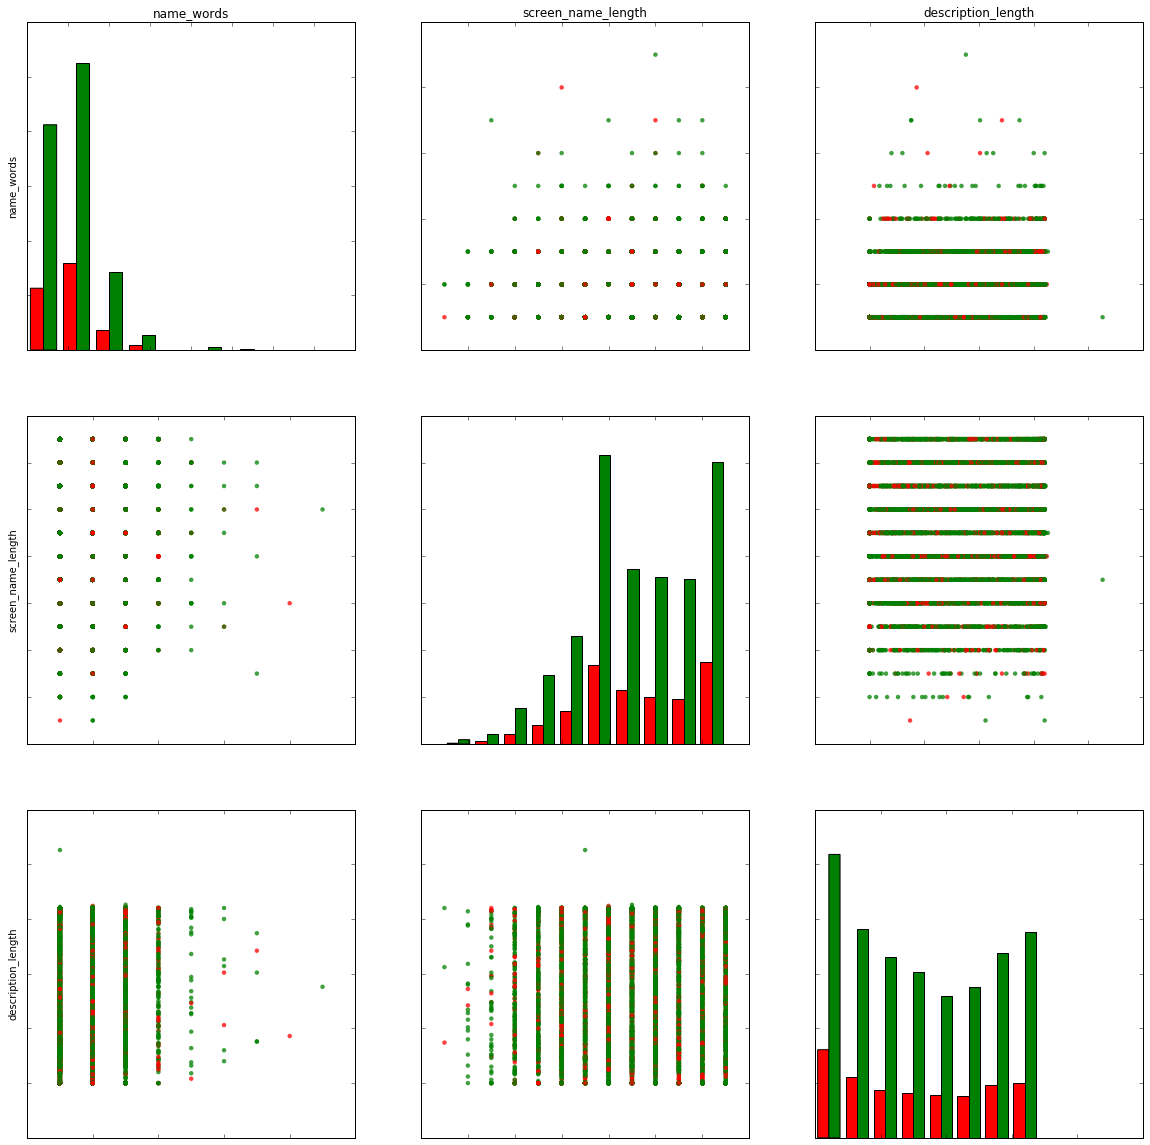

In [15]:
other_features_new = ["name_words", "screen_name_length", "description_length"]
other_features = [f for f in other_features_new if f in features]
other_feature_ind = [features_index_mapper[f] for f in other_features]
plot_dataset(x[:, other_feature_ind], y, other_features)

Итак после первичной обработки данных мы имеем 9 числовых признаков, каждый из которых распределен в некотором своем интервале. Для того, чтобы ни один признак не получил перевеса при кластеризации, нормализуем данные так, что каждый признак распределен на отрезке $[0, 1]$. 

In [16]:
selected_features = ["followers_count", "friends_count", "statuses_count", "favourites_count", 
                     "listed_count", "created_year", "name_words", "screen_name_length", "description_length"]

x_1 = df_users[selected_features].fillna(value=0, inplace=False).values
y = df_users["cls"].values
x_min = x_1.min(axis=0)
x_max = x_1.max(axis=0)
x_new = (x_1 - x_min) / (x_max - x_min)

Упакуем полученную матрицу в pandas DataFrame и сохраним в файл "hw2_out.csv". В следующем задании мы будем кластеризовать пользователей на оновании этих данных.

In [17]:
df_out = pd.DataFrame(data=x_new, index=df_users["uid"], columns=[f for f in selected_features])
df_out.to_csv("hw2_out.csv", sep="\t")